In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from petTOAD_load import *

In [2]:
df_amy_tau = pd.read_csv(UTL_DIR / "UPENNBIOMK_MASTER_FINAL_31Jan2024.csv")
df_petTOAD = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col=0)
# df_petTOAD["RID"] = pd.to_numeric([pt[-4:] for pt in df_petTOAD["PTID"]])
df_petTOAD["wmh_log"] = np.where(df_petTOAD["WMH_load_subj_space"] == 0, 0, np.log10(df_petTOAD["WMH_load_subj_space"]))
df_petTOAD["Acq Date"] = pd.to_datetime(df_petTOAD["Acq Date"])
df_amy_tau["PTID"] = "ADNI" + df_amy_tau["PTID"].str.replace("_","")
df_amy_tau["DRAWDATE"] = pd.to_datetime(df_amy_tau["EXAMDATE"])

In [3]:
# Merge based on 'RID' and date condition
merged_df = pd.merge(df_petTOAD, df_amy_tau, on="PTID")
merged_df = merged_df[
    (merged_df["DRAWDATE"] >= merged_df["Acq Date"] - pd.DateOffset(months=3)) &
    (merged_df["DRAWDATE"] <= merged_df["Acq Date"] + pd.DateOffset(months=3))
]

In [4]:
merged_df["ABETA40"] = pd.to_numeric(merged_df["ABETA40"])
merged_df["ABETA42"] = pd.to_numeric(merged_df["ABETA42"])
merged_df["TAU"] = pd.to_numeric(merged_df["TAU"])
merged_df["ABETA_ratio"] = merged_df["ABETA42"]/merged_df["ABETA40"]

In [5]:
def choose_and_compute_correlation(data, group, column1, column2):
    """
    Tests whether to use Pearson or Spearman correlation and computes it.

    :param data: pandas DataFrame containing the data
    :param column1: Name of the first column for correlation
    :param column2: Name of the second column for correlation
    :return: Correlation value and type (Pearson or Spearman)
    """


    if group != "All":
        data = data[data["Group"] == group]
    # Test for normality
    normality_col1 = stats.shapiro(data[column1])[1] > 0.05  # p-value > 0.05 suggests normal distribution
    normality_col2 = stats.shapiro(data[column2])[1] > 0.05  # p-value > 0.05 suggests normal distribution

    # If both columns are normally distributed, use Pearson's correlation
    if normality_col1 and normality_col2:
        corr, _ = stats.pearsonr(data[column1], data[column2])
        corr_type = 'Pearson'
    else:
        # If either column is not normally distributed, use Spearman's correlation
        corr, p = stats.spearmanr(data[column1], data[column2])
        corr_type = 'Spearman'

    return corr, p, corr_type

Data available for 101 subjects 66 CU and 35 MCI


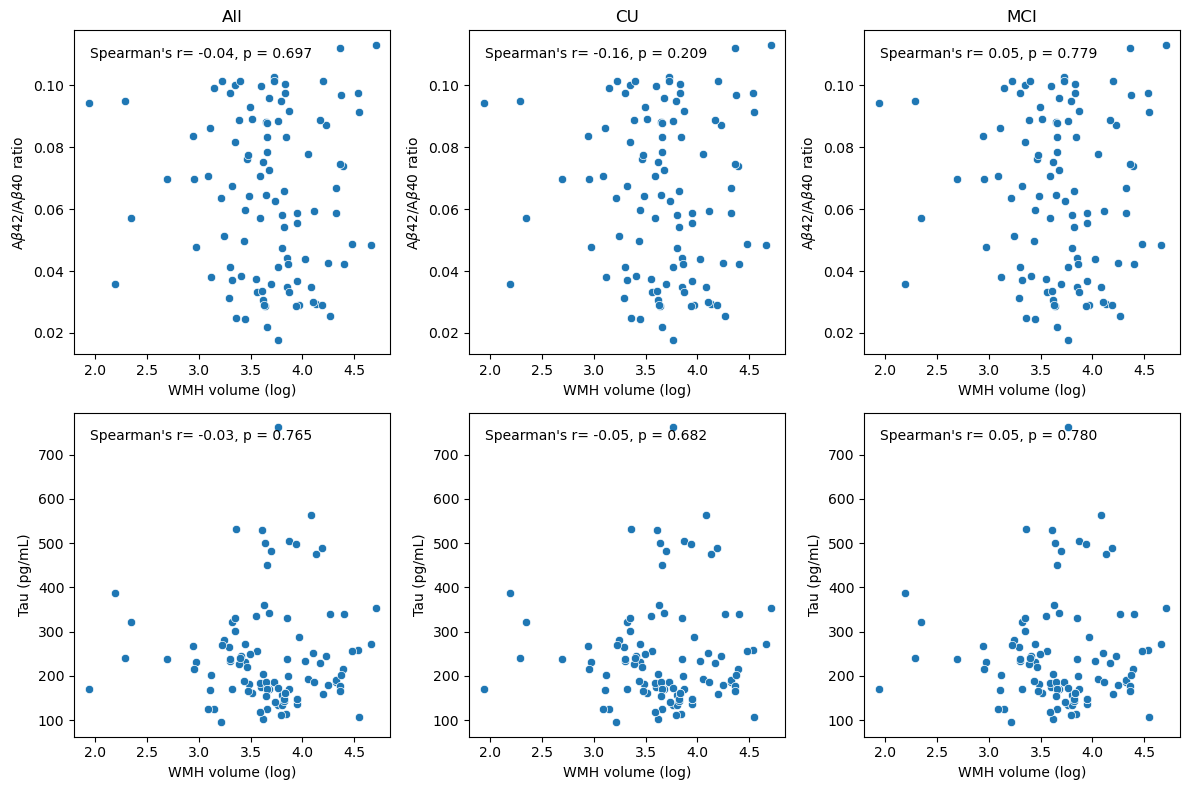

In [6]:
def plot_wmh_bmrks(df, group, axs_row):
    group_dict = {"All": "All",
                  "CN": "CU",
                  "MCI": "MCI"}
    corr_wmh_abeta, p_wmh_abeta, type_wmh_abeta = choose_and_compute_correlation(df, group, "wmh_log", "ABETA_ratio")
    corr_wmh_tau, p_wmh_tau, type_wmh_tau = choose_and_compute_correlation(df, group, "wmh_log", "TAU")
    sns.scatterplot(data = df, x = "wmh_log", y = "ABETA_ratio", ax = axs_row[0])
    sns.scatterplot(data = df, x = "wmh_log", y = "TAU", ax = axs_row[1])
    axs_row[0].set_xlabel("WMH volume (log)")
    axs_row[0].set_ylabel(r"A$\beta$42/A$\beta$40 ratio")
    axs_row[0].text(0.05, 0.95, f"{type_wmh_abeta}'s r= {corr_wmh_abeta:.2f}, p = {p_wmh_abeta:.3f}", verticalalignment='top', horizontalalignment='left', transform=axs_row[0].transAxes)
    axs_row[0].set_title(group_dict[group])
    axs_row[1].set_xlabel("WMH volume (log)")
    axs_row[1].set_ylabel("Tau (pg/mL)")
    axs_row[1].text(0.05, 0.95, f"{type_wmh_tau}'s r= {corr_wmh_tau:.2f}, p = {p_wmh_tau:.3f}", verticalalignment='top', horizontalalignment='left', transform=axs_row[1].transAxes)

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 8))
plot_wmh_bmrks(merged_df, "All", axs[:, 0])
plot_wmh_bmrks(merged_df, "CN", axs[:, 1])
plot_wmh_bmrks(merged_df, "MCI", axs[:, 2])
fig.tight_layout()
print("Data available for", merged_df.shape[0], "subjects", merged_df[merged_df["Group"] == "CN"].shape[0], "CU and", merged_df[merged_df["Group"] == "MCI"].shape[0], "MCI")